# Описание задачи

В этом ноутбуке описан статистический анализ данных применяя критерий Манна-Уитни и бутсрап. 

Задача:
1. Сравнить результат между тестом и контролем по двум кейсам:

Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.

2. Написать выводы, которые можно сделать на основе анализа примененных критериев

In [1]:
#импорт всех необходимых библиотек

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [3]:
#чтение данных
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep = ';')

In [4]:
#проверим, что всё корректно отображается
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [5]:
#проверим датасет на наличие пустых ячеек
df.isna().sum()

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [6]:
#посмотрим, сколько наблюдений в тестовой и контрольной группе
df.groupby('experimentVariant').agg({'value':'count'})

,value
experimentVariant,
Control,500
Treatment,500


In [7]:
#проверим типы данных
df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [8]:
#введем функцию для преобразования колонки value из строки с разделителем "," в число типа float

def to_float(x):
    return float(x.replace(',','.'))

In [9]:
#применим функцию преобразования типов

df.value = df.value.apply(to_float)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

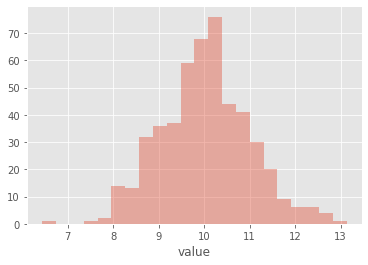

In [10]:
#посмотрим на распределение в контрольной группе

sns.distplot(df[df.experimentVariant == 'Control'].value, kde=False)

<AxesSubplot:xlabel='value'>

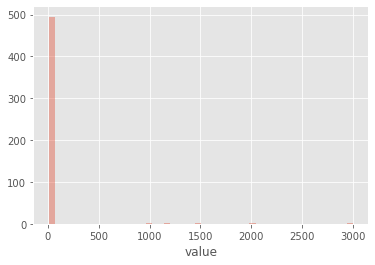

In [11]:
#и тестовой

sns.distplot(df[df.experimentVariant == 'Treatment'].value, kde=False)

Всё уже выглядит странно, но боксплот тоже построим. 😄

<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

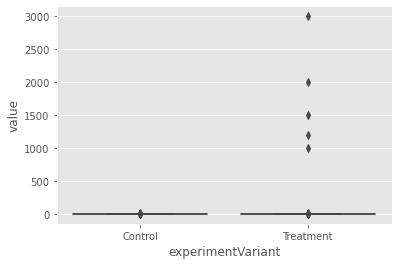

In [12]:
sns.boxplot(x="experimentVariant", y="value", data=df)

In [29]:
#посмотрим на хвост данных
df.tail(10)

,Unnamed: 0,value,experimentVariant
990,991,10.916229,Treatment
991,992,11.160869,Treatment
992,993,8.202518,Treatment
993,994,9.782199,Treatment
994,995,10.484967,Treatment
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment
999,1000,3000.000000,Treatment


Последние 5 значений подозрительно ровные. 🤔

# Формулировка гипотез и проведение тестов

Сформулируем проверяемые гипотезы:

0️⃣Нулевая гипотеза (H0): Разницы между средним value в группе Treatment и группе Control нет.


1️⃣Альтернативная гипотеза (H1): Разница между средним value в группе Treatment и группе Control есть.

Для проверки нулевой гипотезы воспользуемся критерием Манна-Уитни.

In [14]:
mannwhitneyu(df[df.experimentVariant == 'Treatment'].value, 
             df[df.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

🚩 Из величины p_value > 0.05 можно сделать вывод, что => стат значимых различий в группе Treatment и группе Control нет.

Используя U тест можно сделать вывод о принятии H0.

Далее применим бутстрап используя функцию np.mean.

  0%|          | 0/1000 [00:00<?, ?it/s]

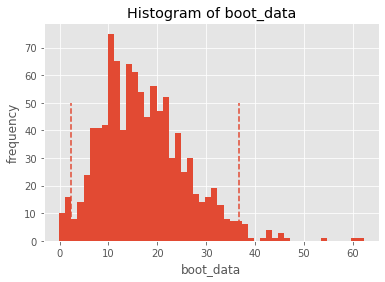

In [15]:
boot_result_mean = get_bootstrap(
    df[df.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    df[df.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [16]:
#посмотрим на p_value
print('P-value =',boot_result_mean.get('p_value'))

P-value = 0.05071828085275565


🚩 Опираясь на значение p_value < 0.05 => Отклоняем нулевую гипотезу о том, что различий в группе Treatment и группе Control нет.

Далее применим бутстрап используя функцию  np.median.

  0%|          | 0/1000 [00:00<?, ?it/s]

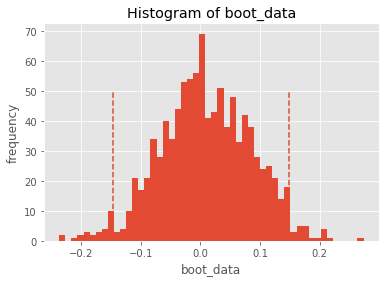

In [18]:
boot_result_median = get_bootstrap(
    df[df.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    df[df.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [19]:
#посмотрим на p_value в этом случае
print('P-value =',boot_result_median.get('p_value'))

P-value = 0.8985541098768556


🚩 Опираясь на значение p_value > 0.05 => Что позволяет принять нулевую гипотезу о том, что различий в группе Treatment и группе Control нет.

Поскольку критерий Манна-Уитни более строгий и нечувствителен к выбросам, а среднее значение - это функция на которую выбросы влияют сильно, есть основания принять H0.

# В чем же дело?

Далее проверим, как поведут себя метод бутстрап применив к исходным данным один из методов обнаружения выбросов.

То есть отфильтровав данные так, чтобы остались только те, которые отличаются не больше чем в полтора раза от первого либо третьего квартилей.

In [21]:
quntile_25_t = df[df.experimentVariant == 'Treatment'].value.quantile(0.25) #вычислим первый квартиль
quntile_75_t = df[df.experimentVariant == 'Treatment'].value.quantile(0.75) #вычислим второй квартиль

interquartile_range_t = quntile_75_t - quntile_25_t #введем пежквартальный размах

a = quntile_25_t - 1.5*interquartile_range_t #определим левую границу интервала
b = quntile_75_t + 1.5*interquartile_range_t #определим левую границу интервала

Далее отфильтруем значения, которые лежат в интервале от a до b.

И визуализиурем полученные результаты.

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

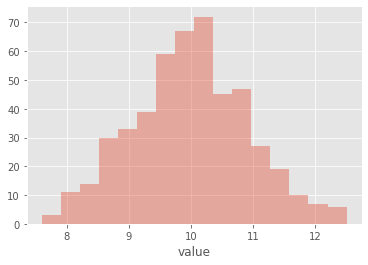

In [22]:
sns.distplot(df[(df.experimentVariant == 'Treatment') & (df.value < b) & (df.value > a)].value, kde=False)

Проведем аналогичную процедуру для группы 'Control'.

In [23]:
quntile_25_c = df[df.experimentVariant == 'Control'].value.quantile(0.25) #вычислим первый квартиль
quntile_75_c = df[df.experimentVariant == 'Control'].value.quantile(0.75) #вычислим второй квартиль

interquartile_range_c = quntile_75_c - quntile_25_c #введем пежквартальный размах

c = quntile_25_c - 1.5*interquartile_range_c #определим левую границу интервала
d = quntile_75_c + 1.5*interquartile_range_c #определим левую границу интервала

Далее отфильтруем значения, которые лежат в интервале от c до d.

Построим гистограмму для полученного распределения.

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

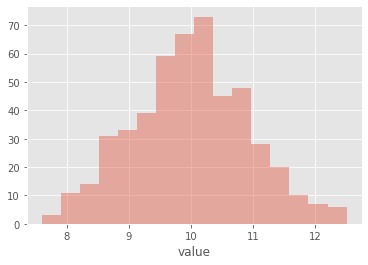

In [24]:
sns.distplot(df[(df.experimentVariant == 'Control') & (df.value < d) & (df.value > c)].value, kde=False)

Так выглядит намного лучше. 😄

И теперь применить бустрап метод к отфильтрованным данным.

  0%|          | 0/1000 [00:00<?, ?it/s]

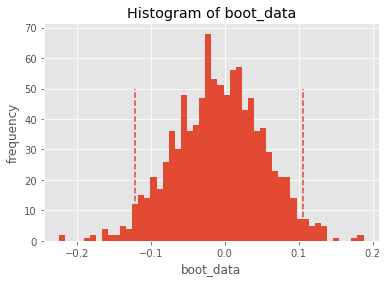

P-value = 0.897770713075055


In [27]:
boot_result_mean_2 = get_bootstrap(
    df[(df.experimentVariant == 'Treatment') & (df.value < b) & (df.value > a)].value, # числовые значения первой выборки
    df[(df.experimentVariant == 'Control') & (df.value < d) & (df.value > c)].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)
       
print('P-value =',boot_result_mean_2.get('p_value'))

  0%|          | 0/1000 [00:00<?, ?it/s]

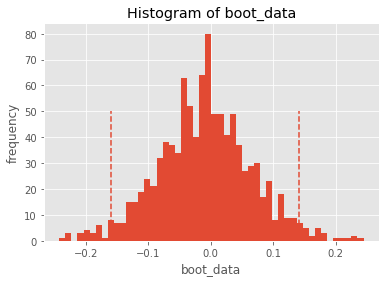

P-value = 0.9041523909172509


In [28]:
boot_result_median_2 = get_bootstrap(
    df[(df.experimentVariant == 'Treatment') & (df.value < b) & (df.value > a)].value, # числовые значения первой выборки
    df[(df.experimentVariant == 'Control') & (df.value < d) & (df.value > c)].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)
       
print('P-value =',boot_result_median_2.get('p_value'))

Для двух случаев (и для функции mean, и для median) p_value >> 0.05 => Из чего заключаем, что нулевую гипотезу отклонять нельзя.

# Выводы:

🚩 Опираясь на на величину p_value критерия Манна-Уитни > 0.05 можно сделать вывод, что => стат значимых различий в Treatment и Control группах нет.

🚩 Наличие аномальных значений в группе Treatment приводит к ошибке первого рода при использовании бутстрап анализа для функции np.mean.

🚩 Наличие аномальных значений в группе Treatment никак не сказывается на результате бутстрап анализа для функции np.median поскольку медианное значение менее чевствительно к наличию выбросов.

🚩 Исключение аномальных значений из выборки позволяет более корректро провести анализ и получить согласованные результаты трех тестов.

P.S. Ощущение, что из контрольной группы 5 значений просто превратили в неадекватно ровные 3000, 2000 и аналогичные числа, чтобы у студентов была возможность тренироваться на кошках.😺